In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidal-mental-health-dataset/mental-health.csv


# Getting the data

In [3]:
data = pd.read_csv('/kaggle/input/suicidal-mental-health-dataset/mental-health.csv')

# Data Processing

In [4]:
data

,text,label
0,I recently went through a breakup and she said...,depression
1,"I do not know how to navigate these feelings, ...",depression
2,"So I have been with my bf for 5 months , and h...",depression
3,I am so exhausted of this. Just when I think I...,SuicideWatch
4,I have been severly bullied since i was 5 till...,depression
...,...,...
20359,I took 50mg of seroquel a few hours after I dr...,SuicideWatch
20360,that is what has happened to me last week. And...,depression
20361,Ever just feel alone in a house full of people...,depression
20362,Politicians. Neighbors. Corporations. Society....,depression


In [5]:
data.describe()

,text,label
count,20364,20364
unique,20339,2
top,#NAME?,depression
freq,9,10371


In [6]:
data.isnull().any()

text     False
label    False
dtype: bool

In [7]:
def char_optmization(df):
    df['text'] = df['text'].str.replace('@\w+', '', regex=True)
    df['text'] = df['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
    emotions = []
    for labels in df.label:
        emotions.append([labels])
    df['emotions'] = pd.Series(emotions, name = 'emotions')
    df = df.drop('label', axis = 1)
    return df
data = char_optmization(data)
data

,text,emotions
0,I recently went through a breakup and she said...,[depression]
1,"I do not know how to navigate these feelings, ...",[depression]
2,"So I have been with my bf for 5 months , and h...",[depression]
3,I am so exhausted of this. Just when I think I...,[SuicideWatch]
4,I have been severly bullied since i was 5 till...,[depression]
...,...,...
20359,I took 50mg of seroquel a few hours after I dr...,[SuicideWatch]
20360,that is what has happened to me last week. And...,[depression]
20361,Ever just feel alone in a house full of people...,[depression]
20362,Politicians. Neighbors. Corporations. Society....,[depression]


In [8]:
from sklearn.model_selection import train_test_split
train_df, alternate = train_test_split(data, test_size = 0.3, stratify = data['emotions'], random_state = 42)
val_df, test_df = train_test_split(alternate, test_size = 0.5, stratify = alternate['emotions'], random_state = 42)
print('No of entries in train_set:', len(train_df))
print('No of entries in test_set:', len(test_df))
print('No of entries in val_set:', len(val_df))

No of entries in train_set: 14254
No of entries in test_set: 3055
No of entries in val_set: 3055


# Multilabel Binarization with StringLookup layers

In [9]:
import tensorflow as tf
import keras
from keras import layers
emotions = tf.ragged.constant(train_df['emotions'].values)

In [10]:
lookup_layer = layers.StringLookup(output_mode = 'one_hot')
lookup_layer.adapt(emotions)

In [11]:
vocabulary = lookup_layer.get_vocabulary()
print(vocabulary)

['[UNK]', 'depression', 'SuicideWatch']


In [12]:
sample_label = train_df['emotions'].iloc[1729]
binarized_label = lookup_layer(sample_label)
print(f"Original Label: {sample_label}")
print(f"Binary Encoded Label: {binarized_label}")

Original Label: ['SuicideWatch']
Binary Encoded Label: [[0 0 1]]


In [13]:
train_df.text.apply(lambda x : len(x.split())).describe()

count    14254.000000
mean       166.238249
std        189.630434
min          1.000000
25%         55.000000
50%        109.000000
75%        209.000000
max       5248.000000
Name: text, dtype: float64

# Creating Tensorflow Dataset

In [14]:
MAX_SEQLEN = 209
BATCH_SIZE = 64
padding_token = "[PAD]"
auto = tf.data.AUTOTUNE

In [15]:
reserved_tokens = [padding_token, "[UNK]"]

In [16]:
def sentiment_analysis(df, training : bool = True):
    labels = tf.ragged.constant(df['emotions'].values)
    binarized_labels = lookup_layer(labels).numpy()

    dataset = tf.data.Dataset.from_tensor_slices(
        (df['text'].values, binarized_labels))
    if training: dataset = dataset.shuffle(BATCH_SIZE * 8)
    return dataset.batch(BATCH_SIZE)

In [17]:
train_dataset = sentiment_analysis(train_df)
val_dataset = sentiment_analysis(val_df)

In [18]:
def invert_onehot(encoded_labels):
    """
    Reverse a one-hot encoded label to its original string label.
    
    Args:
        encoded_labels: A one-hot encoded tensor (or batch of tensors).
    
    Returns:
        Decoded labels as a list of strings.
    """
    # Convert the one-hot tensor to integer indices
    indices = tf.argmax(encoded_labels, axis=-1).numpy()  # Ensure indices are NumPy-compatible
    
    # Use the vocabulary from the lookup layer to map indices back to strings
    vocabulary = lookup_layer.get_vocabulary()
    decoded_labels = [vocabulary[int(index)] for index in indices]
    return decoded_labels


# View the dataset

In [19]:
text_batch, emotion_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[35:55]):
    emotion = emotion_batch[i].numpy()[None, ...]
    print(f"Text: {text.numpy()}\nEmotion: {invert_onehot(emotion)}\n")

Text: b'I am everything that has ever been done to me. I do not want you to haunt me every time I close my eyes. I do not believe in heaven, This is already hell. There is nothing that could be worse than living right now. Help me I am scared. I am afraid. I am afraid of losing. I am afraid of being gone.I am afraid of staying.Every time I look at you I yearn for the time that you did not affect me. You left me alone and yet you will stay forever.Why do my hands hurt. Why why why why why.Maybe I just wish your hands did not make me hurt.Please. Remember me when I am in the ground.Ill meet you again wherever we end up next. I just hope that you will care again. Because I cannot stop caring about you.Maybe I do not want to stop caring about you. Why did you say goodbye. You made me happy . What am I even doing now.Why am I writing a suicide note that I will not kill myself on. Why do I die inside every other week.I cannot take this anymore. Please say you love me. Please say you will sta

<ipython-input-18-cee6520e150a>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  decoded_labels = [vocabulary[int(index)] for index in indices]


## Tokenizing the data

In [21]:
from keras_hub.layers import FNetEncoder
from keras_hub.tokenizers import compute_word_piece_vocabulary, WordPieceTokenizer
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)

VOCAB_SIZE = len(vocabulary)
     

def train_word_piece(dataset, vocab_size, reserved_tokens):
    word_piece_ds = dataset.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [84]:
def train_word_piece(dataset, vocab_size, reserved_tokens):
    word_piece_ds = dataset.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [22]:
vocab = train_word_piece(train_dataset, VOCAB_SIZE, reserved_tokens)
print("Tokens", vocab[:10])

Tokens ['[PAD]', '[UNK]', '!', '"', '#', '$', '%', '&', "'", '(']


In [23]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN
)
     

example = train_dataset.take(1).get_single_element()[0][0]
example_tokens = tokenizer(example)
     

print("Sentence: ", example)
print("Tokens: ", example_tokens)
print("Detokenized Text: ", tokenizer.detokenize(example_tokens))
     

Sentence:  tf.Tensor(b"I do not want to bore anyone with the details of how it came to this, but two friends of mine turned on me in a truly humiliating and nasty way using something I never actually did as an excuse (they said I fat shamed an actor's girlfriend- I did no such thing, I have struggled with EDs myself, I do not do that shit to other people) several years ago.This was traumatic and frightening, it just cane out of absolutely nowhere. They accused me of manipulating then by saying I felt suicidal, that I was fucking mean and horrible person. Just imagine being flayed alive while people scream insults at you and you get the idea.The only reason I never killed myself at that time was because my mum was recovering from some major surgery, so I moved back home for a bit. But none of this has ever truly gone away. They were able to keep track of my movements, which perplexed me because I blocked every account of theirs I was away of.Tl;Dr one of them had an account I discovered

## Formatting the dataset


In [24]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)
     

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=auto)
    return dataset.shuffle(8 * BATCH_SIZE).prefetch(32).cache()
     

train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)

# Making the FNET model

## Hyperparameter Tuning

In [72]:
import keras_tuner as kt
from keras_hub.layers import TokenAndPositionEmbedding
EMBED_DIM = 128
def preprocess_labels(features, labels):
    return features, labels

train_dataset = train_dataset.map(preprocess_labels)
val_dataset = val_dataset.map(preprocess_labels)

def CatharsisSAModel(INTERMEDIATE_DIM, rate, lr, third_layer):
    input_ids = layers.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=VOCAB_SIZE,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=True
    )(input_ids)

    # Run through FNet Layers
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)

    if third_layer:
        x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)

    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(rate)(x)
    outputs = keras.layers.Dense(lookup_layer.vocabulary_size(), activation="sigmoid")(x)

    model = keras.Model(input_ids, outputs, name="CatharsisSAModel")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [73]:
def build_model(hp):
    INTERMEDIATE_DIM = hp.Choice('intermediate_dim', [256, 512, 1024])
    rate = hp.Float('rate', 0.1, 0.2, step=0.1, sampling="linear")
    lr = hp.Float('learning_rate', 1e-5, 1e-3, step=10, sampling='log')
    third_layer = hp.Boolean('third_layer')
    model = CatharsisSAModel(INTERMEDIATE_DIM, rate, lr, third_layer)
    return model

In [74]:
build_model(kt.HyperParameters())

<Functional name=CatharsisSAModel, built=True>

In [75]:
tuner = kt.GridSearch(
    hypermodel = build_model,
    objective = "val_loss",
    overwrite = True,
    max_trials = 17,
    directory = 'CatharsisAI',
    project_name = 'CatharsisFNet'
)

In [76]:
tuner.search(train_dataset, epochs=7, validation_data=val_dataset)

Trial 17 Complete [00h 00m 27s]
val_loss: 0.3909328281879425

Best val_loss So Far: 0.38752481341362
Total elapsed time: 00h 08m 46s


## Get the best model

In [77]:
best_hps = tuner.get_best_hyperparameters(5)
CatharsisFNetModel = build_model(best_hps[0])
CatharsisFNetModel.summary()


Model: "CatharsisSAModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, None, 128)           │       8,961,024 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_2 (FNetEncoder)        │ (None, None, 128)           │          66,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_3 (FNetEncoder)        │ (None, None, 128)           │          66,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,094,275 (34.69 MB)

 Trainable params: 9,094,275 (34.69 MB)

 Non-trainable params: 0 (0.00 B)

# Train the best model

Epoch 1/10
222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5411 - loss: 0.4667
Epoch 1: val_loss improved from inf to 0.41332, saving model to best_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5415 - loss: 0.4665 - val_accuracy: 0.6592 - val_loss: 0.4133
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7072 - loss: 0.3794
Epoch 2: val_loss improved from 0.41332 to 0.38828, saving model to best_model.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7073 - loss: 0.3793 - val_accuracy: 0.7028 - val_loss: 0.3883
Epoch 3/10
218/223 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7928 - loss: 0.2986
Epoch 3: val_loss did not improve from 0.38828
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7932 - loss: 0.2983 - val_accuracy: 0.6903 - val_loss: 0.4254
Epoch 4/10
218/223 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8563 - loss: 0.2267
Epoch 4: val_loss did not improve from 0.38828
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 

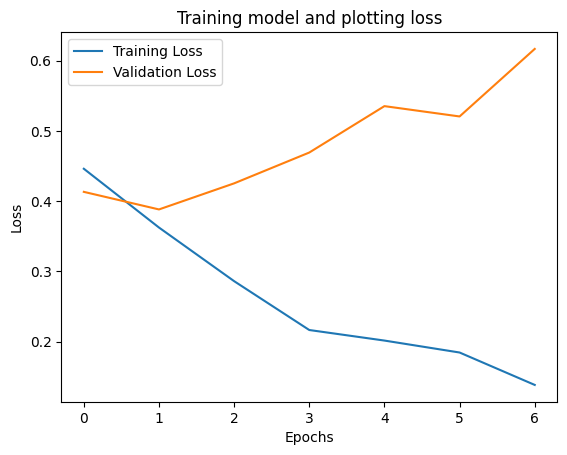

In [78]:
callbacks = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
)
callback_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  # Filepath to save the best model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    verbose=1
)
history = CatharsisFNetModel.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset, 
    verbose = 1,
    callbacks=[callback, callback_model_checkpoint])

import matplotlib.pyplot as plt
line1 = plt.plot(history.history['loss'], label = 'Training Loss')
line2 = plt.plot(history.history['val_loss'], label = 'Validaiton loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training model and plotting loss')
plt.legend(['Training Loss','Validation Loss'])
plt.show()